# Transformación de los datos para las visualizaciones
De acuerdo con lo revisado, inicialmente el dashboard de visualizaciones se va a componer de 2 tabs:
- Tab 1: Va a contener las siguientes visualizaciones:
    - A. Número de estudiantes del IPP.
    - B. Tasa de éxito académico.
    - C. Tasa de deserción.
    - D. Gráfico que compara si el estudiante es becado o no vs si es exitoso o desertor.
    - E. Gráfico de barras con los programas académicos y el porcentaje de estudiantes exitosos y desertores por cada programa.
- Tab 2.
    - F. Diagrama de Sankey que muestra el flujo de las notas de los estudiantes por semestre.

Para ello se tiene que tomar el archivo `data.csv` y transformarlo para que se puedan generar las visualizaciones. Para ello se van a realizar las siguientes transformaciones:
1. Seleccionar las columnas que se van a utilizar.
2. Eliminar los registros que no se van a utilizar (Target = "Enrolled").
3. Discretizar las variables continuas.
4. Exportar el archivo transformado.

## 1. Seleccionar columnas necesarias
Las columnas que se van a utilizar son:
| Índice | Variable                           | Descripción                                           |
| ------ | ---------------------------------- | ----------------------------------------------------- |
| 36     | `Target`                           | Variable objetivo.                                    |
| 15     | `Debtor`                           | Variable que indica si el estudiante es deudor o no.  |
| 16     | `Scholarship`                      | Variable que indica si el estudiante es becado o no.  |
| 3      | `Course`                           | Variable que indica el programa académico.            |
| 12     | `Admission grade`                  | Variable que indica el promedio de admisión.          |
| 25     | `Curricular units 1st sem (grade)` | Variable que indica el promedio del primer semestre.  |
| 31     | `Curricular units 2nd sem (grade)` | Variable que indica el promedio del segundo semestre. |

In [141]:
# Importar librerias
import pandas as pd
import matplotlib.pyplot as plt

In [142]:
# Leer el archivo csv y guardarlo en un dataframe
df = pd.read_csv("data_raw.csv", sep=";")

# Seleccionar las columnas necesarias
columns_to_select = [
    'Target', 'Debtor', 'Scholarship holder', 'Course', 'Admission grade',
    'Curricular units 1st sem (grade)', 'Curricular units 2nd sem (grade)'
]

# Crear un nuevo dataframe con las columnas seleccionadas
df_selected = df[columns_to_select]
df_selected.head()

,Target,Debtor,Scholarship holder,Course,Admission grade,Curricular units 1st sem (grade),Curricular units 2nd sem (grade)
0,Dropout,0,0,171,127.3,0.000000,0.000000
1,Graduate,0,0,9254,142.5,14.000000,13.666667
2,Dropout,0,0,9070,124.8,0.000000,0.000000
3,Graduate,0,0,9773,119.6,13.428571,12.400000
4,Graduate,0,0,8014,141.5,12.333333,13.000000


## 2. Eliminar registros que no se van a utilizar
Se excluyen los registros que tienen como target "Enrolled".

In [143]:
df_selected = df_selected[df_selected['Target'] != 'Enrolled']

## 3. Discretizar variables continuas
Antes de discretizar, vale la pena revisar la distribución de las variables continuas para explorar formas de discretizar.

In [144]:
# Describir las variables admisson grade, curricular units 1st sem (grade) y curricular units 2nd sem (grade)
df_selected[['Admission grade', 'Curricular units 1st sem (grade)', 'Curricular units 2nd sem (grade)']].describe()

,Admission grade,Curricular units 1st sem (grade),Curricular units 2nd sem (grade)
count,3630.000000,3630.000000,3630.000000
mean,127.293939,10.534860,10.036155
std,14.611295,5.057694,5.481742
min,95.000000,0.000000,0.000000
25%,118.000000,11.000000,10.517857
50%,126.500000,12.341429,12.333333
75%,135.100000,13.500000,13.500000
max,190.000000,18.875000,18.571429


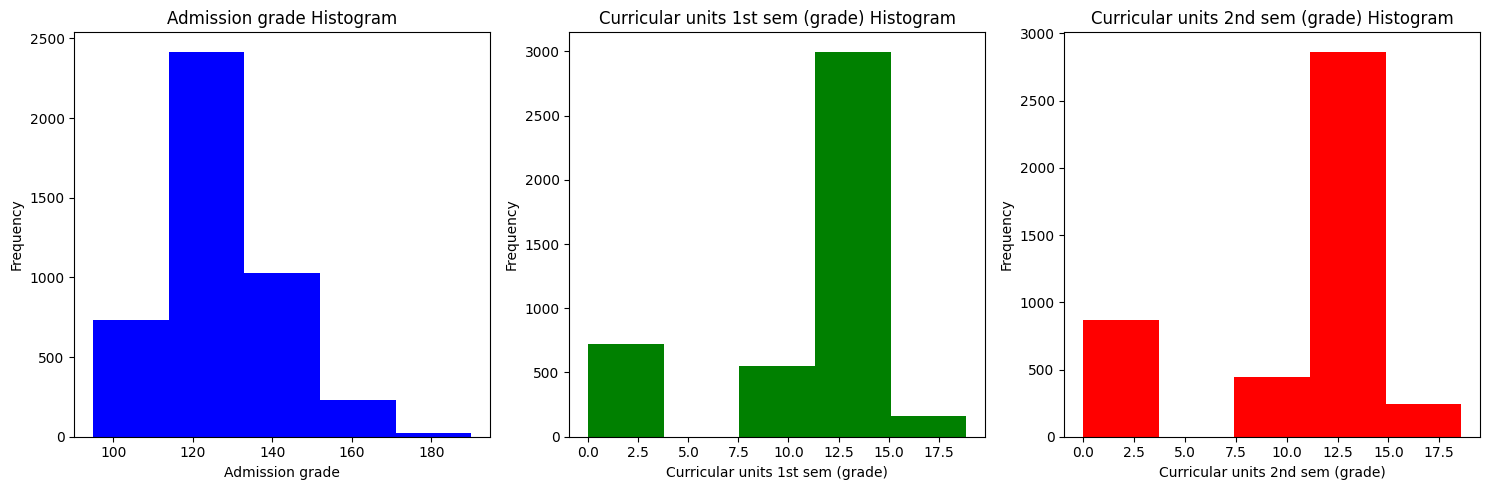

In [145]:
# Variables a graficar
variables_to_plot = ['Admission grade', 'Curricular units 1st sem (grade)', 'Curricular units 2nd sem (grade)']

# Crear subplots para los histogramas
fig, axs = plt.subplots(1, len(variables_to_plot), figsize=(15, 5))

for i, variable in enumerate(variables_to_plot):
    axs[i].hist(df[variable], bins=5, color=['blue', 'green', 'red'][i])
    axs[i].set_title(f'{variable} Histogram')
    axs[i].set_xlabel(variable)
    axs[i].set_ylabel('Frequency')

# Mostrar los histogramas
plt.tight_layout()
plt.show()


Después de experimentar con varias formas de discretizar, se encontró que de acuerdo con la [Partner Information Fact Sheet](https://www.ipportalegre.pt/media/filer_public/06/68/06684969-eeb7-467a-ab6e-053db7fe41a2/fact_sheet.pdf),
 el sistema de calificación del sistema educativo portugués tiene la siguiente escala de desempeño:
- Less than 10 : FAIL (F)
- 10: Minimum pass grade (E)
- 11 - 12: SUFFICIENT (D)
- 13 - 14: GOOD (C)
- 15 – 17: VERY GOOD (B)
- 18 - 20: EXCELLENT (A)

Por ende, se decidió discretizar las variables continuas de la siguiente manera:

In [146]:
# Crear una función para discretizar los puntajes
def discretize_grades(score):
    if score < 10:
        return 'F: FAIL'  # FAIL
    elif 10 <= score < 11:
        return 'E: PASS'  # Minimum pass grade
    elif 11 <= score < 13:
        return 'D: SUFFICIENT'  # SUFFICIENT
    elif 13 <= score < 15:
        return 'C: GOOD'  # GOOD
    elif 15 <= score < 18:
        return 'B: VERY GOOD'  # VERY GOOD
    elif 18 <= score <= 20:
        return 'A: EXCELLENT'  # EXCELLENT

In [147]:
# Crear df_transformed como una copia de df_selected
df_transformed = df_selected.copy()

# Aplicar la función discretize_grades a la columna Admission grade pero dividiendo por 10 antes de aplicar la función
df_transformed['Admission grade'] = df_selected['Admission grade'].apply(lambda x: x / 10).apply(discretize_grades)

# Aplicar la función discretize_grades a la columna Curricular units 1st sem (grade) y a la columna Curricular units 2nd sem (grade)
df_transformed['Curricular units 1st sem (grade)'] = df_selected['Curricular units 1st sem (grade)'].apply(discretize_grades)
df_transformed['Curricular units 2nd sem (grade)'] = df_selected['Curricular units 2nd sem (grade)'].apply(discretize_grades)


---
Validamos que la transformación sea consistente.

In [148]:
# Crear un nuevo DataFrame con las columnas especificadas
new_df = pd.DataFrame({
    'Admission grade (Selected)': df_selected['Admission grade'],
    'Admission grade (Transformed)': df_transformed['Admission grade'],
    'Curricular units 1st sem grade (Selected)': df_selected['Curricular units 1st sem (grade)'],
    'Curricular units 1st sem grade (Transformed)': df_transformed['Curricular units 1st sem (grade)'],
    'Curricular units 2nd sem grade (Selected)': df_selected['Curricular units 2nd sem (grade)'],
    'Curricular units 2nd sem grade (Transformed)': df_transformed['Curricular units 2nd sem (grade)'],
})

# Seleccionar aleatoriamente 10 registros
new_df_sampled = new_df.sample(n=10)

# Mostrar el nuevo DataFrame con 10 registros seleccionados aleatoriamente
new_df_sampled.head(10)

,Admission grade (Selected),Admission grade (Transformed),Curricular units 1st sem grade (Selected),Curricular units 1st sem grade (Transformed),Curricular units 2nd sem grade (Selected),Curricular units 2nd sem grade (Transformed)
2512,132.5,C: GOOD,13.198571,C: GOOD,13.062500,C: GOOD
314,118.5,D: SUFFICIENT,10.500000,E: PASS,0.000000,F: FAIL
1205,130.0,C: GOOD,12.000000,D: SUFFICIENT,13.625000,C: GOOD
2572,110.0,D: SUFFICIENT,12.625000,D: SUFFICIENT,14.166667,C: GOOD
4353,142.8,C: GOOD,0.000000,F: FAIL,0.000000,F: FAIL
1390,131.0,C: GOOD,13.881250,C: GOOD,13.881250,C: GOOD
1521,168.0,B: VERY GOOD,15.200000,B: VERY GOOD,15.200000,B: VERY GOOD
3759,127.3,D: SUFFICIENT,0.000000,F: FAIL,0.000000,F: FAIL
104,117.4,D: SUFFICIENT,0.000000,F: FAIL,0.000000,F: FAIL
2906,115.0,D: SUFFICIENT,11.333333,D: SUFFICIENT,11.333333,D: SUFFICIENT


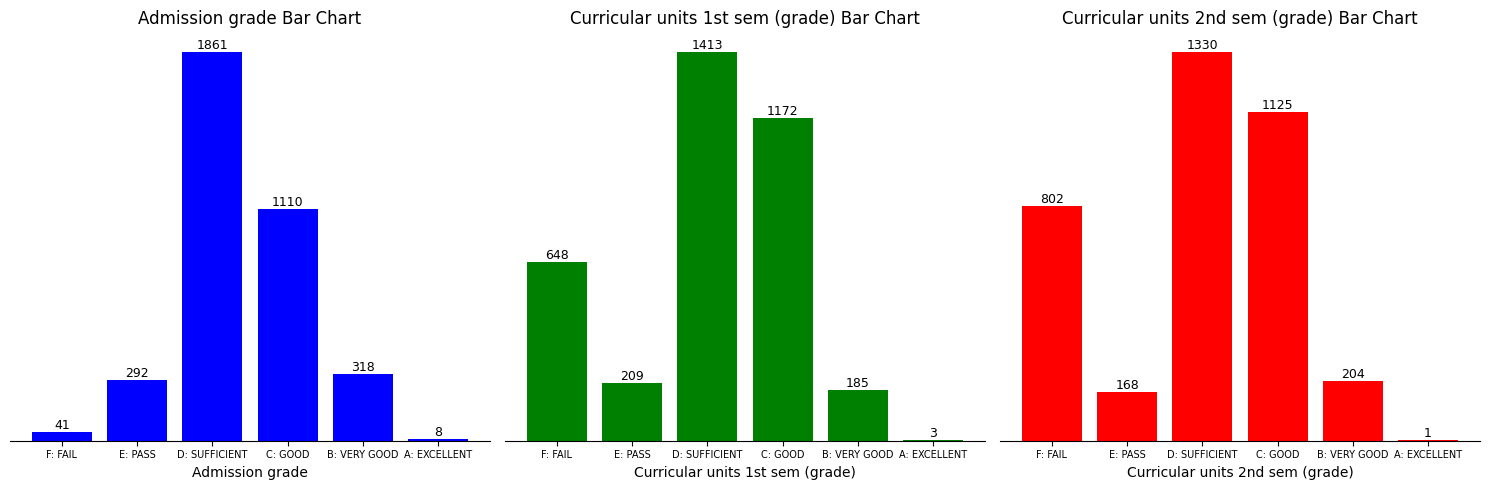

In [149]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
titles = ['Admission grade', 'Curricular units 1st sem (grade)', 'Curricular units 2nd sem (grade)']
colors = ['blue', 'green', 'red']

for i, column in enumerate(['Admission grade', 'Curricular units 1st sem (grade)', 'Curricular units 2nd sem (grade)']):
    ax = axs[i]
    data = df_transformed[column].value_counts().sort_index(ascending=False)
    
    ax.bar(
        data.index,
        data.values,
        color=colors[i],
    )
    
    ax.set_title(f'{titles[i]} Bar Chart')
    ax.set_xlabel(titles[i])
    ax.set_yticks([])  # Elimina los valores del eje y
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    # Colocar las frecuencias como etiquetas dentro de las barras o encima si no caben
    for index, value in enumerate(data.values):
        ax.text(index, value, str(value), ha='center', va='bottom', fontsize=9)

    # Girar las etiquetas del eje x para evitar superposición
    ax.tick_params(axis='x', labelsize=7)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.show()


## 4. Exportar el archivo transformado.

In [150]:
# df_transformed.to_csv('data_viz.csv', sep=',', index=False)